In [39]:
import random
import math
import numpy as np

import copy


import sys, os, time

from qinfer import LiuWestResampler
from qinfer import utils

from qiskit import IBMQ
from qiskit import QuantumCircuit, execute, Aer
import qiskit.ignis.verification.randomized_benchmarking as rb
import matplotlib.lines as mlines

IBMQ.load_account()


/home/alan/aur/miniconda3/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '
ibmqfactory.load_account:WARNING:2021-04-05 22:17:31,504: Credentials are already in use. The existing account in the session will be replaced.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [2]:
import numpy as np
import networkx as nx  # tool to handle general Graphs 
import matplotlib.pyplot as plt 
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, assemble
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

In [3]:
import matplotlib.pyplot as plt
import seaborn as sbs

import smc_linear as smc
Distribution = smc.Distribution

sbs.set(style="darkgrid")

%matplotlib inline

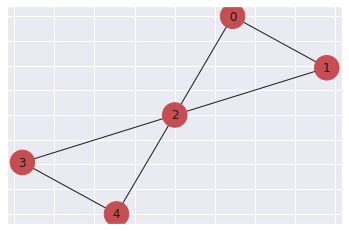

In [4]:
### QAOA CELL
n = 5
V = np.arange(0,n,1)
E =[(0,1,1.0),(0,2,1.0),(1,2,1.0),(3,2,1.0),(3,4,1.0),(4,2,1.0)] 

G = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

# Generate plot of the Graph
colors       = ['r' for node in G.nodes()]
default_axes = plt.axes(frameon=True)
pos          = nx.spring_layout(G)

nx.draw_networkx(G, node_color=colors, node_size=600, alpha=1, ax=default_axes, pos=pos)


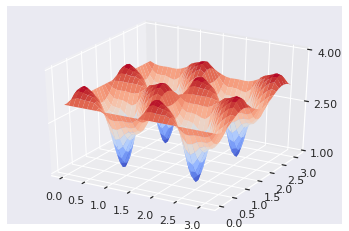


 --- OPTIMAL PARAMETERS --- 

The maximal expectation value is:  M1 = 3.431
This is attained for gamma = 1.900 and beta = 0.200


In [5]:
# Evaluate the function
step_size   = 0.1;

a_gamma         = np.arange(0, np.pi, step_size)
a_beta          = np.arange(0, np.pi, step_size)
a_gamma, a_beta = np.meshgrid(a_gamma,a_beta)

F1 = 3-(np.sin(2*a_beta)**2*np.sin(2*a_gamma)**2-0.5*np.sin(4*a_beta)*np.sin(4*a_gamma))*(1+np.cos(4*a_gamma)**2)

# Grid search for the minimizing variables
result = np.where(F1 == np.amax(F1))
a      = list(zip(result[0],result[1]))[0]

gamma  = a[0]*step_size;
beta   = a[1]*step_size;

# Plot the expetation value F1
fig = plt.figure()
ax  = fig.gca(projection='3d')

surf = ax.plot_surface(a_gamma, a_beta, F1, cmap=cm.coolwarm, linewidth=0, antialiased=True)

ax.set_zlim(1,4)
ax.zaxis.set_major_locator(LinearLocator(3))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

plt.show()

#The smallest parameters and the expectation can be extracted
print('\n --- OPTIMAL PARAMETERS --- \n')
print('The maximal expectation value is:  M1 = %.03f' % np.amax(F1))
print('This is attained for gamma = %.03f and beta = %.03f' % (gamma,beta))

In [6]:
# prepare the quantum and classical resisters
QAOA = QuantumCircuit(len(V), len(V))

# apply the layer of Hadamard gates to all qubits
QAOA.h(range(len(V)))
QAOA.barrier()

# apply the Ising type gates with angle gamma along the edges in E
for edge in E:
    k = edge[0]
    l = edge[1]
    QAOA.cp(-2*gamma, k, l)
    QAOA.p(gamma, k)
    QAOA.p(gamma, l)
    
# then apply the single qubit X rotations with angle beta to all qubits
QAOA.barrier()
QAOA.rx(2*beta, range(len(V)))

# Finally measure the result in the computational basis
QAOA.barrier()
#QAOA.measure(range(len(V)),range(len(V)))

### draw the circuit for comparison
QAOA.draw()

┌───┐ ░            ┌────────┐           ┌────────┐                     »
q_0: ┤ H ├─░──────■─────┤ P(1.9) ├─────■─────┤ P(1.9) ├─────────────────────»
     ├───┤ ░ ┌────┴────┐├────────┤     │     └────────┘           ┌────────┐»
q_1: ┤ H ├─░─┤ P(-3.8) ├┤ P(1.9) ├─────┼────────────────────■─────┤ P(1.9) ├»
     ├───┤ ░ └─────────┘└────────┘┌────┴────┐┌────────┐┌────┴────┐├────────┤»
q_2: ┤ H ├─░──────────────────────┤ P(-3.8) ├┤ P(1.9) ├┤ P(-3.8) ├┤ P(1.9) ├»
     ├───┤ ░                      └─────────┘└────────┘└─────────┘└────────┘»
q_3: ┤ H ├─░────────────────────────────────────────────────────────────────»
     ├───┤ ░                                                                »
q_4: ┤ H ├─░────────────────────────────────────────────────────────────────»
     └───┘ ░                                                                »
c: 5/═══════════════════════════════════════════════════════════════════════»
                                                                            »
«                                                                     ░ »
«q_0: ────────────────────────────────────────────────────────────────░─»
«                                                                     ░ »
«q_1: ────────────────────────────────────────────────────────────────░─»
«     ┌─────────┐┌────────┐                     ┌─────────┐┌────────┐ ░ »
«q_2: ┤ P(-3.8) ├┤ P(1.9) ├─────────────────────┤ P(-3.8) ├┤ P(1.9) ├─░─»
«     └────┬────┘├────────┤           ┌────────┐└────┬────┘└────────┘ ░ »
«q_3: ─────■─────┤ P(1.9) ├─────■─────┤ P(1.9) ├─────┼────────────────░─»
«                └────────┘┌────┴────┐├────────┤     │     ┌────────┐ ░ »
«q_4: ─────────────────────┤ P(-3.8) ├┤ P(1.9) ├─────■─────┤ P(1.9) ├─░─»
«                          └─────────┘└────────┘           └────────┘ ░ »
«c: 5/══════════════════════════════════════════════════════════════════»
«                                                                       »
«     ┌─────────┐ ░ 
«q_0: ┤ RX(0.4) ├─░─
«     ├─────────┤ ░ 
«q_1: ┤ RX(0.4) ├─░─
«     ├─────────┤ ░ 
«q_2: ┤ RX(0.4) ├─░─
«     ├─────────┤ ░ 
«q_3: ┤ RX(0.4) ├─░─
«     ├─────────┤ ░ 
«q_4: ┤ RX(0.4) ├─░─
«     └─────────┘ ░ 
«c: 5/══════════════
«

In [7]:
# Compute the value of the cost function
def cost_function_C(x,G):
    
    E = G.edges()
    if( len(x) != len(G.nodes())):
        return np.nan
        
    C = 0;
    for index in E:
        e1 = index[0]
        e2 = index[1]
        
        w      = G[e1][e2]['weight']
        C = C + w*x[e1]*(1-x[e2]) + w*x[e2]*(1-x[e1])
        
    return C

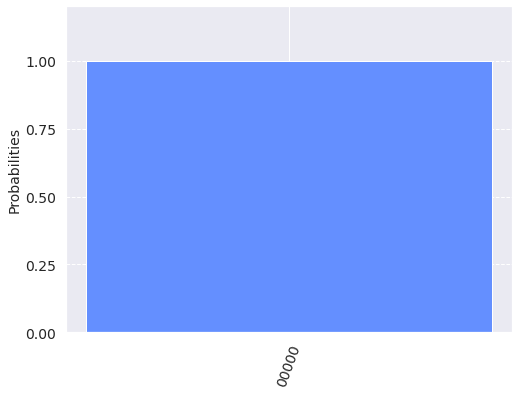

In [8]:
# run on local simulator
backend = Aer.get_backend("qasm_simulator")
shots = 10000

TQAOA = transpile(QAOA, backend)
qobj = assemble(TQAOA)
QAOA_results = backend.run(qobj).result()

plot_histogram(QAOA_results.get_counts(),figsize = (8,6),bar_labels = False)

In [9]:
def design_circuit(n_qubits, inv_arr, circuit=None):
    
    if circuit is None:
        circuit = QuantumCircuit(n_qubits, n_qubits)
    
    for i, element in enumerate(inv_arr):
        if element == 1:
            circuit.x(i)
    
    circuit.measure(list(range(n_qubits)), list(range(n_qubits)))
    return circuit

In [10]:
circuit = QAOA
n_qubits = 5
provider = IBMQ.get_provider(group='open', project='main')
backend = provider.get_backend('ibmq_quito') # ibmq_vigo

n_measurements = 40
n_experiments = 20
n_points = 4000

results = []

for i in range(n_experiments):    

    result_data = {}
    
    

    result_data['circuit'] = circuit
    result_data['risk'] = []
    result_data['mean'] = []
    result_data['len'] = len(circuit)
    
    dist = Distribution(n_points=n_points, n_qubits=n_qubits)


    for _ in range(n_measurements):
        
        inversion_arr = dist.next_experiment()       
        
        tmp_circuit = copy.deepcopy(circuit)
        tmp_circuit = design_circuit(n_qubits, inversion_arr, circuit=tmp_circuit)

        
        job = execute(tmp_circuit, backend, shots=1)
        
        result = job.result()
        outcome = list(map(int, list(list(result.get_counts(circuit).keys())[0])))     
        
        print("Measurements: {} Outcome: {}".format(inversion_arr, outcome))
        dist.measure(outcome, inversion_arr)
        
        result_data['risk'].append(dist.calc_bayes_risk())
        result_data['mean'].append(dist.calc_bayes_mean())

    
    result_data['distrubtion'] = dist
    results.append(result_data)

Measurements: [1, 0, 0, 0, 0] Outcome: [0, 0, 1, 1, 0]
Measurements: [0, 0, 0, 0, 1] Outcome: [0, 1, 1, 1, 1]
Measurements: [0, 0, 0, 1, 0] Outcome: [0, 1, 0, 0, 0]
Measurements: [0, 0, 0, 0, 1] Outcome: [1, 0, 1, 0, 1]
Measurements: [1, 0, 0, 0, 0] Outcome: [1, 1, 1, 1, 1]
Measurements: [0, 0, 0, 0, 1] Outcome: [1, 0, 1, 1, 1]
Measurements: [0, 0, 0, 0, 1] Outcome: [1, 1, 0, 0, 1]
Measurements: [1, 0, 0, 0, 0] Outcome: [0, 0, 0, 0, 0]
Measurements: [0, 0, 0, 0, 1] Outcome: [1, 0, 1, 1, 0]
Measurements: [0, 0, 0, 0, 1] Outcome: [0, 0, 0, 1, 1]
Measurements: [1, 0, 0, 0, 0] Outcome: [0, 1, 1, 0, 1]
Measurements: [1, 0, 0, 0, 0] Outcome: [1, 0, 1, 0, 1]
Measurements: [0, 0, 0, 0, 1] Outcome: [0, 0, 1, 0, 0]
Measurements: [1, 0, 0, 0, 0] Outcome: [1, 0, 0, 0, 0]
Measurements: [0, 0, 0, 0, 1] Outcome: [1, 0, 1, 1, 0]
Measurements: [0, 0, 0, 0, 1] Outcome: [1, 0, 1, 1, 0]
Measurements: [0, 0, 0, 0, 1] Outcome: [1, 0, 1, 0, 0]
Measurements: [1, 0, 0, 0, 0] Outcome: [0, 1, 0, 0, 1]
Measuremen

Measurements: [0, 1, 0, 0, 0] Outcome: [0, 1, 1, 0, 0]
Measurements: [0, 1, 0, 0, 0] Outcome: [1, 0, 0, 1, 0]
Measurements: [0, 1, 0, 0, 0] Outcome: [0, 1, 0, 0, 0]
Measurements: [0, 0, 0, 0, 1] Outcome: [1, 0, 0, 0, 0]
Measurements: [0, 0, 1, 0, 0] Outcome: [1, 0, 0, 0, 0]
Measurements: [0, 0, 1, 0, 0] Outcome: [0, 0, 0, 0, 0]
Measurements: [0, 0, 1, 0, 0] Outcome: [0, 1, 0, 0, 0]
Measurements: [0, 0, 1, 0, 0] Outcome: [0, 0, 1, 0, 0]
Measurements: [0, 0, 0, 0, 1] Outcome: [1, 1, 0, 0, 0]
Measurements: [0, 0, 1, 0, 0] Outcome: [0, 0, 0, 1, 0]
Measurements: [0, 0, 0, 0, 1] Outcome: [1, 0, 0, 0, 1]
Measurements: [0, 1, 0, 0, 0] Outcome: [0, 0, 1, 0, 0]
Measurements: [0, 0, 0, 0, 1] Outcome: [1, 1, 0, 0, 0]
Measurements: [1, 0, 0, 0, 0] Outcome: [1, 1, 1, 0, 1]
Measurements: [0, 0, 0, 1, 0] Outcome: [0, 1, 0, 0, 1]
Measurements: [0, 0, 0, 1, 0] Outcome: [0, 0, 0, 1, 0]
Measurements: [0, 0, 0, 0, 1] Outcome: [1, 1, 0, 0, 1]
Measurements: [0, 0, 0, 1, 0] Outcome: [0, 1, 1, 0, 0]
Measuremen

Measurements: [0, 0, 0, 0, 1] Outcome: [0, 1, 1, 1, 0]
Measurements: [0, 0, 0, 0, 1] Outcome: [0, 1, 0, 0, 1]
Measurements: [0, 0, 0, 1, 0] Outcome: [0, 0, 0, 0, 1]
Measurements: [0, 0, 0, 1, 0] Outcome: [1, 1, 1, 1, 0]
Measurements: [0, 0, 0, 0, 1] Outcome: [1, 0, 1, 0, 1]
Measurements: [0, 0, 0, 1, 0] Outcome: [0, 0, 0, 1, 1]
Measurements: [0, 0, 0, 0, 1] Outcome: [1, 0, 0, 1, 1]
Measurements: [0, 0, 0, 0, 1] Outcome: [0, 1, 0, 1, 1]
Measurements: [0, 0, 0, 1, 0] Outcome: [1, 1, 1, 0, 0]
Measurements: [0, 0, 0, 1, 0] Outcome: [0, 1, 0, 0, 1]
Measurements: [0, 0, 0, 1, 0] Outcome: [0, 1, 0, 1, 0]
Measurements: [0, 0, 0, 1, 0] Outcome: [0, 1, 0, 1, 1]
Measurements: [0, 0, 0, 0, 1] Outcome: [1, 0, 0, 0, 0]
Measurements: [0, 0, 0, 0, 1] Outcome: [1, 0, 0, 1, 0]
Measurements: [0, 0, 0, 0, 1] Outcome: [1, 1, 1, 1, 0]
Measurements: [0, 0, 0, 0, 1] Outcome: [1, 0, 1, 0, 1]
Measurements: [0, 0, 0, 1, 0] Outcome: [1, 0, 0, 1, 1]
Measurements: [0, 0, 0, 0, 1] Outcome: [0, 0, 0, 1, 0]
Measuremen

Measurements: [0, 0, 1, 0, 0] Outcome: [0, 0, 0, 0, 1]
Measurements: [0, 0, 1, 0, 0] Outcome: [0, 1, 0, 1, 0]
Measurements: [0, 0, 1, 0, 0] Outcome: [0, 0, 1, 0, 0]
Measurements: [0, 1, 0, 0, 0] Outcome: [1, 0, 1, 0, 0]
Measurements: [0, 1, 0, 0, 0] Outcome: [1, 1, 0, 1, 0]
Measurements: [0, 1, 0, 0, 0] Outcome: [0, 1, 0, 0, 0]
Measurements: [0, 1, 0, 0, 0] Outcome: [0, 0, 1, 1, 0]
Measurements: [0, 1, 0, 0, 0] Outcome: [1, 1, 0, 0, 0]
Measurements: [0, 1, 0, 0, 0] Outcome: [0, 0, 1, 0, 0]
Measurements: [0, 1, 0, 0, 0] Outcome: [1, 0, 1, 1, 0]
Measurements: [0, 1, 0, 0, 0] Outcome: [0, 1, 0, 0, 1]
Measurements: [0, 1, 0, 0, 0] Outcome: [1, 0, 1, 0, 0]
Measurements: [0, 1, 0, 0, 0] Outcome: [0, 1, 1, 0, 0]
Measurements: [0, 1, 0, 0, 0] Outcome: [0, 1, 1, 1, 0]
Measurements: [0, 1, 0, 0, 0] Outcome: [0, 1, 1, 1, 0]
Measurements: [0, 0, 1, 0, 0] Outcome: [0, 0, 0, 1, 0]
Measurements: [0, 0, 1, 0, 0] Outcome: [0, 0, 1, 0, 1]
Measurements: [0, 1, 0, 0, 0] Outcome: [0, 1, 1, 0, 0]
Measuremen

Measurements: [0, 0, 1, 0, 0] Outcome: [0, 0, 1, 1, 0]
Measurements: [1, 0, 0, 0, 0] Outcome: [0, 0, 0, 1, 1]
Measurements: [1, 0, 0, 0, 0] Outcome: [1, 0, 1, 0, 0]
Measurements: [0, 0, 0, 1, 0] Outcome: [1, 1, 1, 0, 1]
Measurements: [0, 0, 1, 0, 0] Outcome: [0, 0, 0, 1, 0]
Measurements: [1, 0, 0, 0, 0] Outcome: [0, 0, 1, 0, 1]
Measurements: [0, 1, 0, 0, 0] Outcome: [1, 0, 1, 0, 0]
Measurements: [0, 0, 0, 1, 0] Outcome: [0, 1, 0, 0, 1]
Measurements: [0, 1, 0, 0, 0] Outcome: [0, 0, 0, 0, 1]
Measurements: [0, 0, 0, 0, 1] Outcome: [1, 0, 1, 1, 1]
Measurements: [0, 0, 1, 0, 0] Outcome: [0, 0, 0, 0, 0]
Measurements: [0, 0, 1, 0, 0] Outcome: [0, 0, 1, 1, 0]
Measurements: [0, 0, 0, 0, 1] Outcome: [1, 0, 0, 0, 0]
Measurements: [0, 0, 1, 0, 0] Outcome: [0, 0, 0, 1, 0]
Measurements: [0, 0, 1, 0, 0] Outcome: [0, 1, 0, 0, 0]
Measurements: [0, 0, 1, 0, 0] Outcome: [0, 1, 0, 0, 0]
Measurements: [0, 0, 1, 0, 0] Outcome: [1, 0, 0, 0, 1]
Measurements: [0, 0, 1, 0, 0] Outcome: [0, 0, 0, 0, 1]
Measuremen

Measurements: [0, 1, 0, 0, 0] Outcome: [0, 0, 1, 1, 0]
Measurements: [0, 1, 0, 0, 0] Outcome: [0, 0, 1, 1, 0]
Measurements: [0, 1, 0, 0, 0] Outcome: [0, 0, 1, 0, 1]
Measurements: [0, 1, 0, 0, 0] Outcome: [0, 0, 1, 1, 1]
Measurements: [1, 0, 0, 0, 0] Outcome: [0, 0, 0, 0, 1]
Measurements: [0, 1, 0, 0, 0] Outcome: [1, 1, 0, 0, 0]
Measurements: [0, 1, 0, 0, 0] Outcome: [0, 0, 1, 1, 0]
Measurements: [0, 1, 0, 0, 0] Outcome: [0, 1, 1, 0, 0]
Measurements: [0, 1, 0, 0, 0] Outcome: [0, 1, 0, 0, 0]
Measurements: [0, 1, 0, 0, 0] Outcome: [0, 0, 1, 1, 1]
Measurements: [1, 0, 0, 0, 0] Outcome: [1, 0, 1, 0, 0]
Measurements: [1, 0, 0, 0, 0] Outcome: [0, 0, 1, 1, 1]
Measurements: [0, 0, 0, 1, 0] Outcome: [0, 1, 0, 0, 0]
Measurements: [0, 0, 0, 1, 0] Outcome: [1, 1, 0, 1, 0]
Measurements: [0, 0, 0, 1, 0] Outcome: [0, 1, 0, 1, 1]
Measurements: [1, 0, 0, 0, 0] Outcome: [0, 0, 1, 0, 1]
Measurements: [0, 1, 0, 0, 0] Outcome: [0, 0, 1, 1, 0]
Measurements: [1, 0, 0, 0, 0] Outcome: [0, 1, 1, 0, 1]
Measuremen

In [40]:
IBMQ.load_account()

ibmqfactory.load_account:WARNING:2021-04-05 22:17:42,930: Credentials are already in use. The existing account in the session will be replaced.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

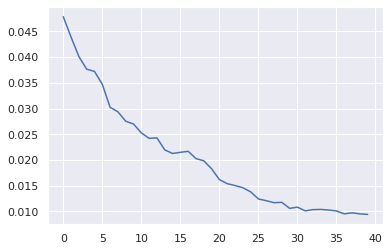

In [25]:
plt.plot(results[3]['risk'])

In [33]:
np.zeros(n_qubits, dtype=int)

array([0, 0, 0, 0, 0])

In [57]:
provider = IBMQ.get_provider(group='open', project='main')
backend = provider.get_backend('ibmq_quito') # ibmq_vigo

for i, result in enumerate(results):
    
    
    tmp_circuit = copy.deepcopy(result['circuit'])
    inv_arr = np.zeros(n_qubits, dtype=int)
    
    tmp_circuit = design_circuit(n_qubits, inv_arr, circuit=tmp_circuit)
    job = execute(tmp_circuit, backend, shots=1024)
    ibm_result = job.result()
    
    results[i]['initial'] = ibm_result
    
    inv_arr = result['distrubtion'].next_experiment()
    
    tmp_circuit = copy.deepcopy(result['circuit'])
    tmp_circuit = design_circuit(n_qubits, inv_arr, circuit=tmp_circuit)
    job = execute(tmp_circuit, backend, shots=1024)
    ibm_result = job.result() 
    
    results[i]['final'] = ibm_result
    
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [68]:
print(max([max(i['initial'].get_counts().values()) for i in results]))
print(max([max(i['final'].get_counts().values()) for i in results]))

109
114


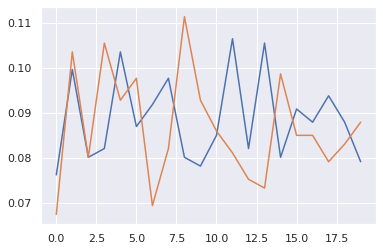

In [66]:
plt.plot([max(i['initial'].get_counts().values()) / 1024 for i in results]) 
plt.plot([max(i['final'].get_counts().values()) / 1024 for i in results])


 --- SIMULATION RESULTS ---

The sampled mean value is M1_sampled = 0.00 while the true value is M1 = 3.43 

The approximate solution is x* = 00001 with C(x*) = 2 

The cost function is distributed as: 



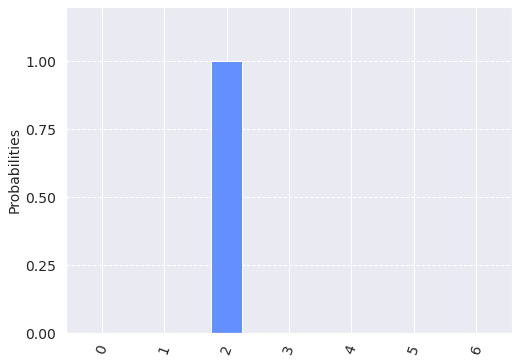

In [12]:
# Evaluate the data from the simulator
counts = result.get_counts()

avr_C       = 0
max_C       = [0,0]
hist        = {}

for k in range(len(G.edges())+1):
    hist[str(k)] = hist.get(str(k),0)

for sample in list(counts.keys()):

    # use sampled bit string x to compute C(x)
    x         = [int(num) for num in list(sample)]
    tmp_eng   = cost_function_C(x,G)
    
    # compute the expectation value and energy distribution
    avr_C     = avr_C    + counts[sample]*tmp_eng
    hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)),0) + counts[sample]
    
    # save best bit string
    if( max_C[1] < tmp_eng):
        max_C[0] = sample
        max_C[1] = tmp_eng
                
M1_sampled   = avr_C/shots

print('\n --- SIMULATION RESULTS ---\n')
print('The sampled mean value is M1_sampled = %.02f while the true value is M1 = %.02f \n' % (M1_sampled,np.amax(F1)))
print('The approximate solution is x* = %s with C(x*) = %d \n' % (max_C[0],max_C[1]))
print('The cost function is distributed as: \n')
plot_histogram(hist,figsize = (8,6),bar_labels = False)

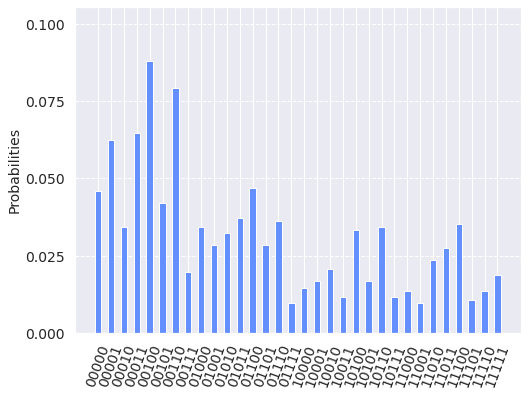

In [62]:
plot_histogram(results[i]['final'].get_counts(),figsize = (8,6),bar_labels = False)

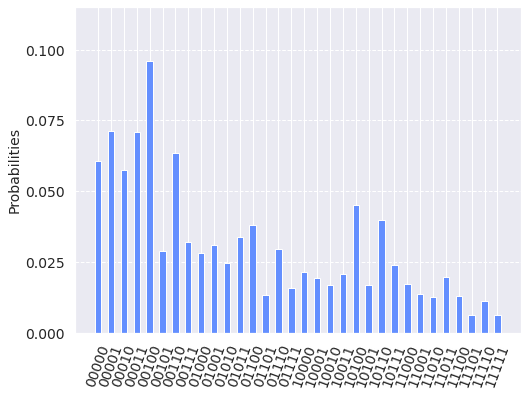

In [24]:
backend = provider.get_backend('ibmq_quito')
shots = 10000
job = execute(tmp_circuit, backend, shots=8192)
QAOA_results = job.result()
plot_histogram(QAOA_results.get_counts(),figsize = (8,6),bar_labels = False)

In [ ]:
backend = provider.get_backend('ibmq_quito')
shots = 10000
job = execute(tmp_circuit, backend, shots=1)
QAOA_results = job.result()
plot_histogram(QAOA_results.get_counts(),figsize = (8,6),bar_labels = False)

In [22]:
circuit.draw()

┌───┐ ░            ┌────────┐           ┌────────┐                     »
q_0: ┤ H ├─░──────■─────┤ P(1.9) ├─────■─────┤ P(1.9) ├─────────────────────»
     ├───┤ ░ ┌────┴────┐├────────┤     │     └────────┘           ┌────────┐»
q_1: ┤ H ├─░─┤ P(-3.8) ├┤ P(1.9) ├─────┼────────────────────■─────┤ P(1.9) ├»
     ├───┤ ░ └─────────┘└────────┘┌────┴────┐┌────────┐┌────┴────┐├────────┤»
q_2: ┤ H ├─░──────────────────────┤ P(-3.8) ├┤ P(1.9) ├┤ P(-3.8) ├┤ P(1.9) ├»
     ├───┤ ░                      └─────────┘└────────┘└─────────┘└────────┘»
q_3: ┤ H ├─░────────────────────────────────────────────────────────────────»
     ├───┤ ░                                                                »
q_4: ┤ H ├─░────────────────────────────────────────────────────────────────»
     └───┘ ░                                                                »
c: 5/═══════════════════════════════════════════════════════════════════════»
                                                                            »
«                                                                     ░ »
«q_0: ────────────────────────────────────────────────────────────────░─»
«                                                                     ░ »
«q_1: ────────────────────────────────────────────────────────────────░─»
«     ┌─────────┐┌────────┐                     ┌─────────┐┌────────┐ ░ »
«q_2: ┤ P(-3.8) ├┤ P(1.9) ├─────────────────────┤ P(-3.8) ├┤ P(1.9) ├─░─»
«     └────┬────┘├────────┤           ┌────────┐└────┬────┘└────────┘ ░ »
«q_3: ─────■─────┤ P(1.9) ├─────■─────┤ P(1.9) ├─────┼────────────────░─»
«                └────────┘┌────┴────┐├────────┤     │     ┌────────┐ ░ »
«q_4: ─────────────────────┤ P(-3.8) ├┤ P(1.9) ├─────■─────┤ P(1.9) ├─░─»
«                          └─────────┘└────────┘           └────────┘ ░ »
«c: 5/══════════════════════════════════════════════════════════════════»
«                                                                       »
«     ┌─────────┐ ░ 
«q_0: ┤ RX(0.4) ├─░─
«     ├─────────┤ ░ 
«q_1: ┤ RX(0.4) ├─░─
«     ├─────────┤ ░ 
«q_2: ┤ RX(0.4) ├─░─
«     ├─────────┤ ░ 
«q_3: ┤ RX(0.4) ├─░─
«     ├─────────┤ ░ 
«q_4: ┤ RX(0.4) ├─░─
«     └─────────┘ ░ 
«c: 5/══════════════
«

In [19]:
tmp_circuit.draw()

┌───┐ ░            ┌────────┐           ┌────────┐                     »
q_0: ┤ H ├─░──────■─────┤ P(1.9) ├─────■─────┤ P(1.9) ├─────────────────────»
     ├───┤ ░ ┌────┴────┐├────────┤     │     └────────┘           ┌────────┐»
q_1: ┤ H ├─░─┤ P(-3.8) ├┤ P(1.9) ├─────┼────────────────────■─────┤ P(1.9) ├»
     ├───┤ ░ └─────────┘└────────┘┌────┴────┐┌────────┐┌────┴────┐├────────┤»
q_2: ┤ H ├─░──────────────────────┤ P(-3.8) ├┤ P(1.9) ├┤ P(-3.8) ├┤ P(1.9) ├»
     ├───┤ ░                      └─────────┘└────────┘└─────────┘└────────┘»
q_3: ┤ H ├─░────────────────────────────────────────────────────────────────»
     ├───┤ ░                                                                »
q_4: ┤ H ├─░────────────────────────────────────────────────────────────────»
     └───┘ ░                                                                »
c: 5/═══════════════════════════════════════════════════════════════════════»
                                                                            »
«                                                                     ░ »
«q_0: ────────────────────────────────────────────────────────────────░─»
«                                                                     ░ »
«q_1: ────────────────────────────────────────────────────────────────░─»
«     ┌─────────┐┌────────┐                     ┌─────────┐┌────────┐ ░ »
«q_2: ┤ P(-3.8) ├┤ P(1.9) ├─────────────────────┤ P(-3.8) ├┤ P(1.9) ├─░─»
«     └────┬────┘├────────┤           ┌────────┐└────┬────┘└────────┘ ░ »
«q_3: ─────■─────┤ P(1.9) ├─────■─────┤ P(1.9) ├─────┼────────────────░─»
«                └────────┘┌────┴────┐├────────┤     │     ┌────────┐ ░ »
«q_4: ─────────────────────┤ P(-3.8) ├┤ P(1.9) ├─────■─────┤ P(1.9) ├─░─»
«                          └─────────┘└────────┘           └────────┘ ░ »
«c: 5/══════════════════════════════════════════════════════════════════»
«                                                                       »
«     ┌─────────┐ ░      ┌─┐         
«q_0: ┤ RX(0.4) ├─░──────┤M├─────────
«     ├─────────┤ ░ ┌───┐└╥┘      ┌─┐
«q_1: ┤ RX(0.4) ├─░─┤ X ├─╫───────┤M├
«     ├─────────┤ ░ └┬─┬┘ ║       └╥┘
«q_2: ┤ RX(0.4) ├─░──┤M├──╫────────╫─
«     ├─────────┤ ░  └╥┘  ║ ┌─┐    ║ 
«q_3: ┤ RX(0.4) ├─░───╫───╫─┤M├────╫─
«     ├─────────┤ ░   ║   ║ └╥┘┌─┐ ║ 
«q_4: ┤ RX(0.4) ├─░───╫───╫──╫─┤M├─╫─
«     └─────────┘ ░   ║   ║  ║ └╥┘ ║ 
«c: 5/════════════════╩═══╩══╩══╩══╩═
«                     2   0  3  4  1